TO CLARIFY

THE MODEL TO BE EVALUATED IS THE ONE BUILT UNDER THE "BEST MODEL" SECTION OF THE NOTEBOOK, USING THE FUNCTION build_unet.

THE SCORES ARE SHOWN UNDER THE "FINAL SCORE" SECTION OF THE NOTEBOOK.

#Blind Source Separation - July 29th Exam
**Task** 

The task consists in decomposing an image obtained as a sum of a two images img1 and img2 into its components.

The network takes in input the sum img1+img2 and returns the predicted components hat_img1 and hat_img2.

No preprocessing is allowed. 

**Data**

The source images img1 and img2 come from different datasets: mnist and fashion_mnist, respectively.

In this notebook you may find a trace, providing generators and examples.

**Structure**

Write a notebook explaining every step you take and DON'T clear the output of the cells when you submit it.  

You may possibly discuss and provide results for more models, but at most a couple of them should be presented in the notebook.

Make sure to test the model in order to prove robustness and lack of overfitting.

The metric you will need to use to evaluate the results is the mean squared error between predicted and ground truth images.

Evaluate the mse over 20000 samples randomly generated from the two test_sets.

Repeat the computation 10 times and check the standard deviation, that should be very small.

**Recommendation**

Save the weights of your model and keep them until the discussion, we might ask you to provide them. 

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist, fashion_mnist

import numpy as np
from matplotlib import pyplot as plt

from tensorflow import keras as ks
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
import os

In [ ]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
print(np.shape(mnist_x_train))
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()
#normnalize in and pad
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
print(np.shape(mnist_x_train))
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
4431872/4422102 [==============================] - 0s 0us/step
(60000, 32, 32)


In [ ]:
print(np.shape(mnist_x_train))

(60000, 32, 32)


In [ ]:
def datagenerator(x1,x2,batchsize):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = np.concatenate((x1[num1], x2[num2]), axis=2)

        yield x_data, y_data 

In [ ]:
batchsize = 64
inputShape = (32,32,1)

In [ ]:
train_generator = datagenerator(mnist_x_train,fashion_mnist_x_train,batchsize)
val_generator = datagenerator(mnist_x_train,fashion_mnist_x_train,batchsize)
test_generator = datagenerator(mnist_x_test,fashion_mnist_x_test,batchsize)

#train_generator = datagenerator(mnist_x_train,fashion_mnist_x_train,1)
#val_generator = datagenerator(mnist_x_train,fashion_mnist_x_train,1)
test_generator1 = datagenerator(mnist_x_test,fashion_mnist_x_test,1)

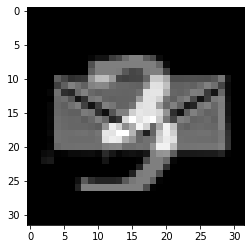

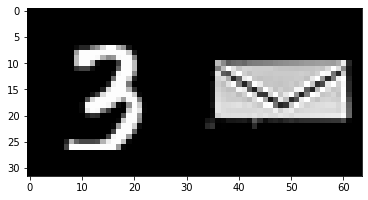

(32, 32)
(64, 32, 64)


In [ ]:
x, y = next(train_generator)
plt.imshow(x[0],cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y[0], cmap='gray', interpolation='nearest')
plt.show()
print(x[0].shape)
print(y.shape)

In [ ]:
input_shape = (32, 32, 1)
learning_rate = 1e-3

#my code

My immediate idea was to use a unet.
I found a paper talking about semi siamese unets, which are basic unets, in which the upsampling part is split into two, in order to generate two different images that are then concatenated into one.
The paper in question is: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7853495/


I applied that basic idea, and obtained good results. 


After that i tried to improve my model, by adding some layers. This gave me some better results, so this final model is my best model.
Hence the model built using the function **build_unet**, called **unet_model**, is the one to be evaluated


**SEMI-SIAMESE MODEL** section -> original idea

**BEST MODEL** section -> improved model, which is my BEST ONE

in the section **final score** i show my final results

#semi-siamese model

**the model**

this model is like a basic unet, but the difference from it stands in the upsampling part. In the downsampling part there is only one encoder, while in the upsampling part there are two decoders. This way the net is fed one single 32x32 image, and it produces two 32x32 images, which are then concatnated at the last layer of the network to produce a 32x64 image, which is then compared to the ground truth.

In [ ]:
def build_semi_siamese(input_shape, n_ch=32, L=4, conv_per_L=2):
  x = ks.layers.Input(shape=input_shape)

  backup_layers = []
  h = x

  for l in range(L):
    for c in range(conv_per_L):
      h = ks.layers.Conv2D(n_ch, 3, 1, padding='same')(h)
      h = ks.layers.ReLU()(h)

    if l < L-1: # We don't want to downsample at the last level
            # Downsample
      backup_layers.append(h) # save for the skip connection 
      h = ks.layers.MaxPool2D(padding='same')(h)
      
            # Update the channels
      n_ch = n_ch * 2
 
  h1 = h
  h2 = h

   # UP (pay attention to do not double count the last level)
  for l in range(L-1):
        # Reduce the channels
      n_ch = n_ch // 2

        # Upsample
      h1 = ks.layers.Conv2DTranspose(n_ch, 3, 2, padding='same')(h1)
      h2 = ks.layers.Conv2DTranspose(n_ch, 3, 2, padding='same')(h2)


        # Concatenate
      
      b = backup_layers.pop(-1)

      h1 = ks.layers.concatenate([h1, b])
      h2 = ks.layers.concatenate([h2, b])
      
        # Each floor in the up phase
      for c in range(conv_per_L):
          h1 = ks.layers.Conv2D(n_ch, 3, 1, padding='same')(h1)
          h1 = ks.layers.ReLU()(h1)

          h2 = ks.layers.Conv2D(n_ch, 3, 1, padding='same')(h2)
          h2 = ks.layers.ReLU()(h2)

   # Output
  y1 = ks.layers.Conv2D(1, 1, activation='sigmoid')(h1)
  y2 = ks.layers.Conv2D(1, 1, activation='sigmoid')(h2)

  y = ks.layers.concatenate([y1, y2], axis=2)

  return ks.models.Model(x, y)

In [ ]:
semi_siamese = build_semi_siamese(input_shape)

In [ ]:
semi_siamese.compile(optimizer=ks.optimizers.Adam(learning_rate=learning_rate),
                  loss = 'binary_crossentropy',
                  metrics=['mse'])

**training**

in using 3000 steps_per_epochs and a batch size of 64 (given by the data generator), it is like using 192000 images, which exploits the two datasets to their full potential, without weighing too much on the ram.

In [ ]:
N_EPOCHS = 50
STEPS_PER_EPOCH = 3000
VALIDATION_STEPS = 300

monitor = 'val_mse'
working_dir = 'semiSiamese'
checkpoint_dir = os.path.join(working_dir, 'ckpt')
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
checkpoint_filepath = os.path.join(checkpoint_dir, 'bestweightsSiamese.h5')

#early_stopping_callback = ks.callbacks.EarlyStopping(monitor=monitor, patience=5, verbose=1, mode='min', restore_best_weights=True)
#reduce_on_plateau_callback = ks.callbacks.ReduceLROnPlateau(monitor='loss', min_lr=1e-5, factor=0.5, patience=3, verbose=1, mode='min')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor=monitor, mode='min', save_weights_only=True, save_best_only=True)

callbacks = [
    #reduce_on_plateau_callback,
    #early_stopping_callback,
    model_checkpoint_callback,
]

# Training
#unet_model.load_weights("unet_semi_siamese_weights.h5")

history_semi_siamese = semi_siamese.fit(train_generator, validation_data = val_generator,
              epochs=N_EPOCHS,
              steps_per_epoch = STEPS_PER_EPOCH,
              validation_steps = VALIDATION_STEPS,
              callbacks = callbacks)

Epoch 1/50
3000/3000 [==============================] - 91s 26ms/step - loss: 0.1283 - mse: 0.0041 - val_loss: 0.1201 - val_mse: 0.0015
Epoch 2/50
3000/3000 [==============================] - 77s 26ms/step - loss: 0.1192 - mse: 0.0013 - val_loss: 0.1190 - val_mse: 0.0011
Epoch 3/50
3000/3000 [==============================] - 77s 26ms/step - loss: 0.1183 - mse: 0.0010 - val_loss: 0.1185 - val_mse: 9.1387e-04
Epoch 4/50
3000/3000 [==============================] - 80s 27ms/step - loss: 0.1178 - mse: 8.9929e-04 - val_loss: 0.1176 - val_mse: 9.1457e-04
Epoch 5/50
3000/3000 [==============================] - 77s 26ms/step - loss: 0.1175 - mse: 8.1806e-04 - val_loss: 0.1179 - val_mse: 7.5733e-04
Epoch 6/50
3000/3000 [==============================] - 79s 26ms/step - loss: 0.1175 - mse: 7.8734e-04 - val_loss: 0.1171 - val_mse: 7.8213e-04
Epoch 7/50
3000/3000 [==============================] - 77s 26ms/step - loss: 0.1174 - mse: 7.7002e-04 - val_loss: 0.1170 - val_mse: 7.7291e-04
Epoch 8/50
3

In [ ]:
semi_siamese.save_weights("unet_semi_siamese_weights.h5")
semi_siamese.save("unet_semi_siamese.h5")

In [ ]:
def display_history(history):
    mse_training = history.history['loss']
    acc_training = history.history['mse']

    mse_val = history.history['val_loss']
    acc_val = history.history['val_mse']

 # Visualize the behavior of the loss
    plt.plot(mse_training)
    plt.plot(mse_val)
    plt.grid()
    plt.title('Loss during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

    # and of the accuracy
    plt.plot(acc_training)
    plt.plot(acc_val)
    plt.grid()
    plt.title('Accuracy during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

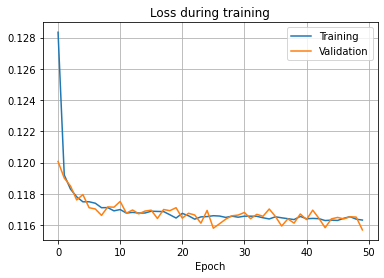

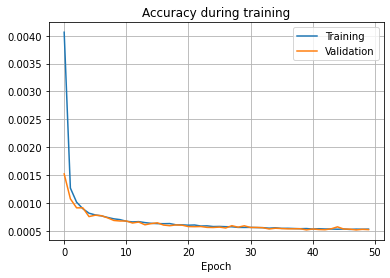

In [ ]:
display_history(history_semi_siamese)

**evaluation**

the model_checkpoint_callback is utilized to load the best weights of the training into the model before doing the evaluation.

In [ ]:
semi_siamese.load_weights("semiSiamese/ckpt/bestweightsSiamese.h5")
scores = semi_siamese.evaluate(test_generator, steps = 315)
print(scores[1])

315/315 [==============================] - 3s 10ms/step - loss: 0.1172 - mse: 5.2296e-04
0.0005229554953984916


In [ ]:
mse_arr = np.zeros(10)

for i in range(10):
  scores = semi_siamese.evaluate(test_generator, steps = 315)
  print(scores[1])
  mse_arr[i] = scores[1]

315/315 [==============================] - 3s 10ms/step - loss: 0.1169 - mse: 5.1727e-04
0.0005172655219212174
315/315 [==============================] - 3s 10ms/step - loss: 0.1171 - mse: 5.2084e-04
0.0005208438960835338
315/315 [==============================] - 3s 10ms/step - loss: 0.1169 - mse: 5.2490e-04
0.0005248956731520593
315/315 [==============================] - 3s 10ms/step - loss: 0.1170 - mse: 5.2175e-04
0.0005217542056925595
315/315 [==============================] - 3s 11ms/step - loss: 0.1174 - mse: 5.3091e-04
0.0005309077096171677
315/315 [==============================] - 3s 10ms/step - loss: 0.1168 - mse: 5.2060e-04
0.000520598201546818
315/315 [==============================] - 3s 10ms/step - loss: 0.1170 - mse: 5.1169e-04
0.0005116933025419712
315/315 [==============================] - 3s 10ms/step - loss: 0.1169 - mse: 5.1533e-04
0.0005153315141797066
315/315 [==============================] - 3s 10ms/step - loss: 0.1170 - mse: 5.1638e-04
0.0005163801833987236
31

In [ ]:
standard_deviation=np.std(mse_arr, dtype=np.double) 
print("standard deviation: ", standard_deviation)
mean = np.mean(mse_arr, dtype=np.float32)
print("mean: ", mean)

standard deviation:  5.2669988920109855e-06
mean:  0.0005195044


In [ ]:
test_size = 2
x_test = np.zeros([test_size, 32, 32])
y_test = np.zeros([test_size, 32, 64])
for j in range(test_size) :
  x_test[j], y_test[j] = next(test_generator1)
  y_pred = semi_siamese.predict(x_test)

In [ ]:
def show(x, y, title=None):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(x, cmap='gray')
    if title:
        plt.title(title[0])
    
    plt.subplot(1, 2, 2)
    plt.imshow(y,cmap='gray')
    if title:
        plt.title(title[1])

    plt.show()

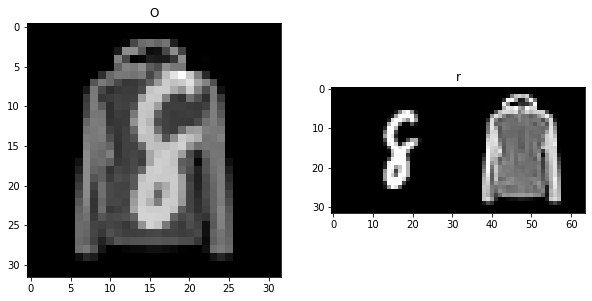

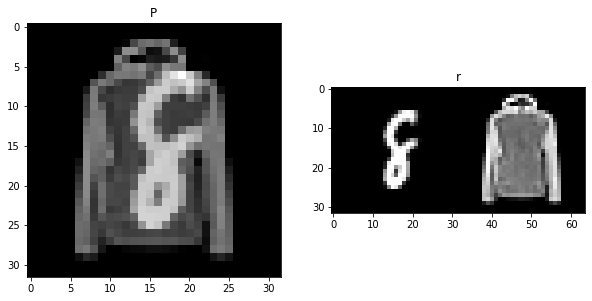

In [ ]:
y_pred = semi_siamese.predict(x_test[:1])

show(x_test[0, :, :], y_test[0, :, :], title='Original')
show(x_test[0, :, :], y_pred[0, :, :, 0], title='Predicted')

#BEST MODEL

**the model**

this model is similar to the semi_siamese one, as there are two parts in the upsampling aspect of the model. This allows the model to produce two 32x32 images from a single one, and these two images are then concatenated into a 32x64 one which is then compared to the ground truth.

The difference from the semi_siamese model, is that there are some additional layers, and that the basic structure is slightly different since the parameter L is now 3 instead of 4, and conv_per_L is now 3 instead of 2. 
In every for cycle there are now 2 convolutional layers, and after the maxpool operation there is an additional dropout layer to avoid overfitting, an additional ReLU layer and a batch normalization layer.
In the upsampling layer, aside from the fact that the signal has become two separate signals, there is an extra batch normalization layer for each of them

THIS IS THE MODEL TO BE EVALUATED

In [ ]:
def build_unet(input_shape, n_ch=32, L=3, conv_per_L=3):  #33
  x = ks.layers.Input(shape=input_shape)

  backup_layers = []
  h = x

  for l in range(L):
    for c in range(conv_per_L):
      h = ks.layers.Conv2D(n_ch, 3, 1, padding='same')(h)
      h = ks.layers.ReLU()(h)
      h = ks.layers.Conv2D(n_ch, 3, 1, padding='same')(h)

    if l < L-1: # We don't want to downsample at the last level
            # Downsample
      backup_layers.append(h) # save for the skip connection 
      h = ks.layers.MaxPool2D(padding='same')(h)
      h = Dropout(.2)(h)
      h = ks.layers.ReLU()(h)
      h = ks.layers.BatchNormalization()(h)
      
            # Update the channels
      n_ch = n_ch * 2
 
  h1 = h
  h2 = h

   # UP (pay attention to do not double count the last level)
  for l in range(L-1):
        # Reduce the channels
      n_ch = n_ch // 2

        # Upsample
      h1 = ks.layers.Conv2DTranspose(n_ch, 3, 2, padding='same')(h1)
      h2 = ks.layers.Conv2DTranspose(n_ch, 3, 2, padding='same')(h2)


        # Concatenate
      
      b = backup_layers.pop(-1)

      h1 = ks.layers.concatenate([h1, b])
      h2 = ks.layers.concatenate([h2, b])
      
        # Each floor in the up phase
      for c in range(conv_per_L):
          h1 = ks.layers.Conv2D(n_ch, 3, 1, padding='same')(h1)
          h1 = ks.layers.ReLU()(h1)
          h1 = ks.layers.BatchNormalization()(h1)

          h2 = ks.layers.Conv2D(n_ch, 3, 1, padding='same')(h2)
          h2 = ks.layers.ReLU()(h2)
          h2 = ks.layers.BatchNormalization()(h2)

   # Output
  y1 = ks.layers.Conv2D(1, 1, activation='sigmoid')(h1)
  y2 = ks.layers.Conv2D(1, 1, activation='sigmoid')(h2)

  y = ks.layers.concatenate([y1, y2], axis=2)

  return ks.models.Model(x, y)

In [ ]:
unet_model = build_unet(input_shape)

In [ ]:
unet_model.compile(optimizer=ks.optimizers.Adam(learning_rate=learning_rate),
                  loss = 'binary_crossentropy',
                  metrics=['mse'])

**training**

in using 3000 steps_per_epochs and a batch size of 64 (given by the data generator), it is like using 192000 images, which exploits the two datasets to their full potential, without weighing too much on the ram.

the model checkpoint callback is used to save the best weights obtained by the training in order to load them onto the model before the evaluation

In [ ]:
N_EPOCHS = 50
STEPS_PER_EPOCH = 3000
VALIDATION_STEPS = 300

monitor = 'val_mse'
working_dir = 'bestunet'
checkpoint_dir = os.path.join(working_dir, 'ckpt')
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
checkpoint_filepath = os.path.join(checkpoint_dir, 'bestweights.h5')

#early_stopping_callback = ks.callbacks.EarlyStopping(monitor=monitor, patience=5, verbose=1, mode='min', restore_best_weights=True)
#reduce_on_plateau_callback = ks.callbacks.ReduceLROnPlateau(monitor='loss', min_lr=1e-5, factor=0.5, patience=3, verbose=1, mode='min')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor=monitor, mode='min', save_weights_only=True, save_best_only=True)

callbacks = [
    #reduce_on_plateau_callback,
    #early_stopping_callback,
    model_checkpoint_callback,
]

# Training
#unet_model.load_weights("unet_model_weights.h5")

history_unet = unet_model.fit(train_generator, validation_data = val_generator,
              epochs=N_EPOCHS,
              steps_per_epoch = STEPS_PER_EPOCH,
              validation_steps = VALIDATION_STEPS,
              callbacks = callbacks)

Epoch 1/50
3000/3000 [==============================] - 103s 34ms/step - loss: 0.1380 - mse: 0.0054 - val_loss: 0.1236 - val_mse: 0.0027
Epoch 2/50
3000/3000 [==============================] - 100s 33ms/step - loss: 0.1197 - mse: 0.0014 - val_loss: 0.1209 - val_mse: 0.0017
Epoch 3/50
3000/3000 [==============================] - 100s 33ms/step - loss: 0.1185 - mse: 0.0011 - val_loss: 0.1181 - val_mse: 9.9562e-04
Epoch 4/50
3000/3000 [==============================] - 100s 33ms/step - loss: 0.1180 - mse: 9.5020e-04 - val_loss: 0.1178 - val_mse: 8.3696e-04
Epoch 5/50
3000/3000 [==============================] - 101s 34ms/step - loss: 0.1176 - mse: 8.4721e-04 - val_loss: 0.1171 - val_mse: 7.6230e-04
Epoch 6/50
3000/3000 [==============================] - 100s 33ms/step - loss: 0.1175 - mse: 7.9894e-04 - val_loss: 0.1189 - val_mse: 0.0011
Epoch 7/50
3000/3000 [==============================] - 100s 33ms/step - loss: 0.1171 - mse: 7.3096e-04 - val_loss: 0.1171 - val_mse: 6.2323e-04
Epoch 8/5

In [ ]:
unet_model.save_weights("unet_model_weights.h5")
unet_model.save("unet_model.h5")

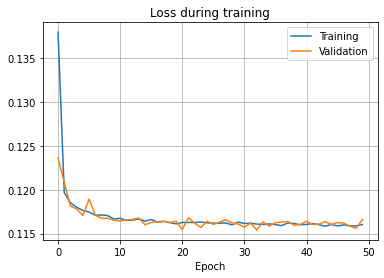

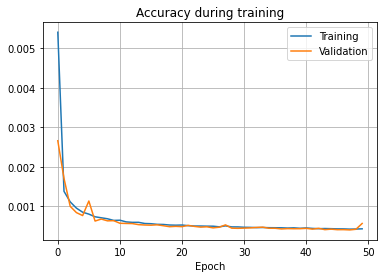

In [ ]:
display_history(history_unet)

#score
after the same amounts of epochs, this unet_model performs better than the basic semi_siamese model.

In [ ]:
unet_model.load_weights("bestunet/ckpt/bestweights.h5")
scores = unet_model.evaluate(test_generator, steps = 315)
print(scores[1])

315/315 [==============================] - 3s 11ms/step - loss: 0.1165 - mse: 4.0132e-04
0.0004013174620922655


the model is evaluated 10 times, using 20000 images each (batchsize of 64 x 315 steps per epoch = 20160 images)

In [ ]:
mse_arr = np.zeros(10)

for i in range(10):
  scores = unet_model.evaluate(test_generator, steps = 315)
  print(scores[1])
  mse_arr[i] = scores[1]

315/315 [==============================] - 4s 12ms/step - loss: 0.1164 - mse: 4.0499e-04
0.00040498640737496316
315/315 [==============================] - 3s 11ms/step - loss: 0.1163 - mse: 4.0534e-04
0.0004053361772093922
315/315 [==============================] - 3s 11ms/step - loss: 0.1166 - mse: 4.0391e-04
0.0004039072373416275
315/315 [==============================] - 3s 11ms/step - loss: 0.1165 - mse: 4.0533e-04
0.000405333616072312
315/315 [==============================] - 3s 11ms/step - loss: 0.1164 - mse: 4.0588e-04
0.0004058793419972062
315/315 [==============================] - 3s 11ms/step - loss: 0.1165 - mse: 4.0163e-04
0.00040162791265174747
315/315 [==============================] - 3s 11ms/step - loss: 0.1166 - mse: 4.0428e-04
0.0004042813670821488
315/315 [==============================] - 3s 11ms/step - loss: 0.1166 - mse: 4.0434e-04
0.0004043426306452602
315/315 [==============================] - 3s 11ms/step - loss: 0.1169 - mse: 4.0947e-04
0.00040947122033685446

In [ ]:
standard_deviation=np.std(mse_arr, dtype=np.double) 
print("standard deviation: ",standard_deviation)
mean = np.mean(mse_arr, dtype=np.float32)
print("mean: ", mean)

standard deviation:  1.8623155842606868e-06
mean:  0.00040497346


In [ ]:
test_size = 2
x_test = np.zeros([test_size, 32, 32])
y_test = np.zeros([test_size, 32, 64])
for j in range(test_size) :
  x_test[j], y_test[j] = next(test_generator1)
  y_pred = unet_model.predict(x_test)

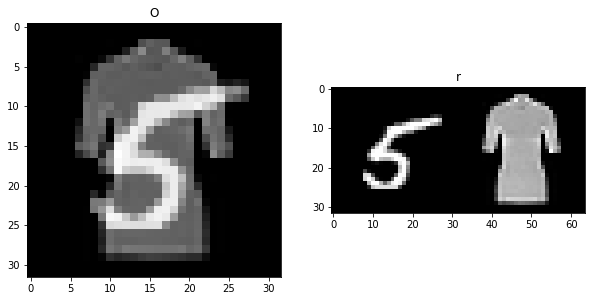

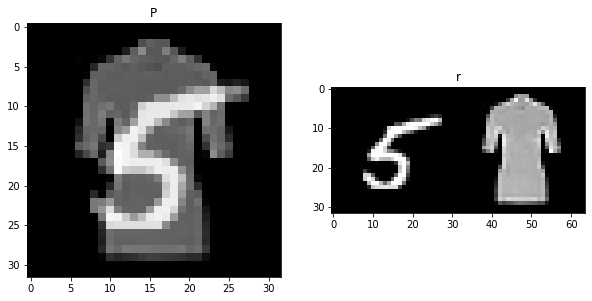

In [ ]:
y_pred = unet_model.predict(x_test[:1])

show(x_test[0, :, :], y_test[0, :, :], title='Original')
show(x_test[0, :, :], y_pred[0, :, :, 0], title='Predicted')

#extensive training
while after 50 epochs the score is already quite good, the model can still be trained. Hence why I did some additional training to reach the best score possible, since the model does not stop learning after only 50 epochs, but can learn for many more.

In [ ]:
N_EPOCHS = 100
STEPS_PER_EPOCH = 3000
VALIDATION_STEPS = 300

monitor = 'val_mse'
working_dir = 'bestunetextensive'
checkpoint_dir = os.path.join(working_dir, 'ckpt')
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
checkpoint_filepath = os.path.join(checkpoint_dir, 'bestweightsExtensive.h5')

#early_stopping_callback = ks.callbacks.EarlyStopping(monitor=monitor, patience=5, verbose=1, mode='min', restore_best_weights=True)
#reduce_on_plateau_callback = ks.callbacks.ReduceLROnPlateau(monitor='loss', min_lr=1e-5, factor=0.5, patience=3, verbose=1, mode='min')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor=monitor, mode='min', save_weights_only=True, save_best_only=True)

callbacks = [
    #reduce_on_plateau_callback,
    #early_stopping_callback,
    model_checkpoint_callback,
]

# Training
unet_model.load_weights("bestunet/ckpt/bestweights.h5")

history_unet_extensive = unet_model.fit(train_generator, validation_data = val_generator,
              epochs=N_EPOCHS,
              steps_per_epoch = STEPS_PER_EPOCH,
              validation_steps = VALIDATION_STEPS,
              callbacks = callbacks)

Epoch 1/100
3000/3000 [==============================] - 106s 34ms/step - loss: 0.1160 - mse: 4.2350e-04 - val_loss: 0.1156 - val_mse: 4.0742e-04
Epoch 2/100
3000/3000 [==============================] - 103s 34ms/step - loss: 0.1160 - mse: 4.2241e-04 - val_loss: 0.1155 - val_mse: 4.0524e-04
Epoch 3/100
3000/3000 [==============================] - 103s 34ms/step - loss: 0.1159 - mse: 4.1535e-04 - val_loss: 0.1157 - val_mse: 4.0904e-04
Epoch 4/100
3000/3000 [==============================] - 103s 34ms/step - loss: 0.1160 - mse: 4.1468e-04 - val_loss: 0.1153 - val_mse: 3.9920e-04
Epoch 5/100
3000/3000 [==============================] - 103s 34ms/step - loss: 0.1161 - mse: 4.1330e-04 - val_loss: 0.1161 - val_mse: 3.9606e-04
Epoch 6/100
3000/3000 [==============================] - 103s 34ms/step - loss: 0.1159 - mse: 4.1854e-04 - val_loss: 0.1157 - val_mse: 3.9652e-04
Epoch 7/100
3000/3000 [==============================] - 105s 35ms/step - loss: 0.1158 - mse: 4.0989e-04 - val_loss: 0.1163 

In [ ]:
unet_model.save_weights("unet_model_extensive_weights.h5")
unet_model.save("unet_model_extensive.h5")

#FINAL SCORE
after the additional training of the model, the final result is indeed better because, even if more slowly, the model keeps learning beyond the 50 initial epochs.
In this section I show my final results, using the unet_model

In [ ]:
unet_model.load_weights("bestunetextensive/ckpt/bestweightsExtensive.h5")
scores = unet_model.evaluate(test_generator, steps = 315)
print(scores[1])

315/315 [==============================] - 3s 11ms/step - loss: 0.1163 - mse: 3.4948e-04
0.00034947803942486644


the model is evaluated 10 times, using 20000 images each (batchsize of 64 x 315 steps per epoch = 20160 images)

In [ ]:
mse_arr = np.zeros(10)

for i in range(10):
  scores = unet_model.evaluate(test_generator, steps = 315)
  print(scores[1])
  mse_arr[i] = scores[1]

315/315 [==============================] - 3s 11ms/step - loss: 0.1161 - mse: 3.5116e-04
0.0003511610848363489
315/315 [==============================] - 3s 11ms/step - loss: 0.1162 - mse: 3.5195e-04
0.0003519500605762005
315/315 [==============================] - 3s 11ms/step - loss: 0.1166 - mse: 3.5077e-04
0.00035076873609796166
315/315 [==============================] - 3s 11ms/step - loss: 0.1162 - mse: 3.4731e-04
0.0003473091055639088
315/315 [==============================] - 3s 11ms/step - loss: 0.1164 - mse: 3.5167e-04
0.0003516661818139255
315/315 [==============================] - 3s 10ms/step - loss: 0.1166 - mse: 3.4812e-04
0.00034811929799616337
315/315 [==============================] - 3s 11ms/step - loss: 0.1164 - mse: 3.4969e-04
0.0003496857243590057
315/315 [==============================] - 3s 11ms/step - loss: 0.1168 - mse: 3.5568e-04
0.0003556798037607223
315/315 [==============================] - 3s 10ms/step - loss: 0.1164 - mse: 3.5111e-04
0.000351107883034274


In [ ]:
standard_deviation=np.std(mse_arr, dtype=np.double) 
print("standard deviation: ", standard_deviation)
mean = np.mean(mse_arr, dtype=np.float32)
print("mean: ", mean)

standard deviation:  2.1745779184893657e-06
mean:  0.00035074804


In [ ]:
test_size = 2
x_test = np.zeros([test_size, 32, 32])
y_test = np.zeros([test_size, 32, 64])
for j in range(test_size) :
  x_test[j], y_test[j] = next(test_generator1)
  y_pred = unet_model.predict(x_test)

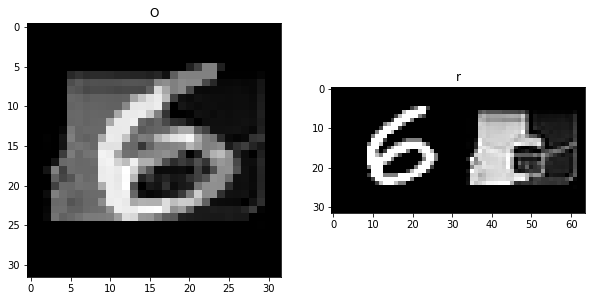

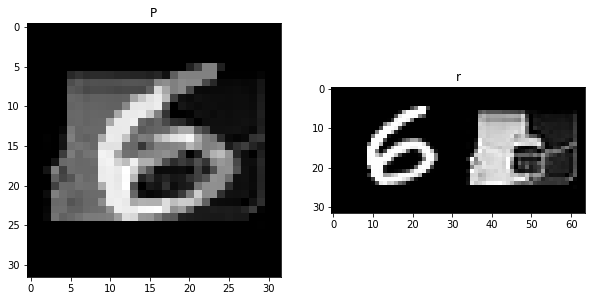

In [ ]:
y_pred = unet_model.predict(x_test[:1])

show(x_test[0, :, :], y_test[0, :, :], title='Original')
show(x_test[0, :, :], y_pred[0, :, :, 0], title='Predicted')

**conclusions**

the values obtained after training the unet_model are:


standard deviation:  2.1745779184893657e-06


mean:  0.00035074804

TO CLARIFY

THE MODEL TO BE EVALUATED IS THE ONE BUILT UNDER THE "BEST MODEL" SECTION OF THE NOTEBOOK, USING THE FUNCTION build_unet.

THE SCORES ARE SHOWN UNDER THE "FINAL SCORE" SECTION OF THE NOTEBOOK.